### Loading Packages and Data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [7]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data

binned_ldl_exposure_time.csv  state_person_time.csv  ylls.csv
binned_sbp_exposure_time.csv  transition_count.csv
deaths.csv                    ylds.csv


In [11]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data/'

### Exploring Data

In [12]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
#deaths.head()

In [13]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
#tran.transition.unique()

In [14]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

person_time.value.sum()

3069572019.143054

# DALYs Averted

In [15]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total = daly_total.groupby(['sex','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

sex  input_draw  year       scenario           daly
0  Female          29  2021       baseline  457035.055409
1  Female          29  2021  lifestyle_100  457035.055409
2  Female          29  2021   outreach_100  457035.055409
3  Female          29  2021   polypill_100  457035.055409
4  Female          29  2022       baseline  439535.488452

In [16]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.loc[person_time.age != '25_to_29']
per_time_age = per_time_age.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw       scenario       ptvalue
0  Female  2021          29       baseline  1.876066e+06
1  Female  2021          29  lifestyle_100  1.876066e+06
2  Female  2021          29   outreach_100  1.876066e+06
3  Female  2021          29   polypill_100  1.876066e+06
4  Female  2021         232       baseline  1.856508e+06

In [17]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario           daly       ptvalue  \
0  Female          29  2021       baseline  457035.055409  1.876066e+06   
1  Female          29  2021  lifestyle_100  457035.055409  1.876066e+06   
2  Female          29  2021   outreach_100  457035.055409  1.876066e+06   
3  Female          29  2021   polypill_100  457035.055409  1.876066e+06   
4  Female          29  2022       baseline  439535.488452  1.754710e+06   

   daly_rate  
0   0.243613  
1   0.243613  
2   0.243613  
3   0.243613  
4   0.250489

In [18]:
daly_total_baseline = daly_total.loc[daly_total.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly':'baseline'})
daly_total = daly_total.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total['averted_count'] = daly_total['baseline'] - daly_total['daly']
daly_total['averted_percent'] = 100*((daly_total['baseline'] - daly_total['daly'])/daly_total['baseline'])
daly_total.head()

sex  input_draw  year       scenario           daly       baseline  \
0  Female          29  2021       baseline  457035.055409  457035.055409   
1  Female          29  2021  lifestyle_100  457035.055409  457035.055409   
2  Female          29  2021   outreach_100  457035.055409  457035.055409   
3  Female          29  2021   polypill_100  457035.055409  457035.055409   
4  Female          29  2022       baseline  439535.488452  439535.488452   

   averted_count  averted_percent  
0            0.0              0.0  
1            0.0              0.0  
2            0.0              0.0  
3            0.0              0.0  
4            0.0              0.0

In [19]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['baseline'] - daly_total_rate['daly_rate']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['baseline'] - daly_total_rate['daly_rate'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario           daly       ptvalue  \
0  Female          29  2021       baseline  457035.055409  1.876066e+06   
1  Female          29  2021  lifestyle_100  457035.055409  1.876066e+06   
2  Female          29  2021   outreach_100  457035.055409  1.876066e+06   
3  Female          29  2021   polypill_100  457035.055409  1.876066e+06   
4  Female          29  2022       baseline  439535.488452  1.754710e+06   

   daly_rate  baseline  averted_count  averted_percent  
0   0.243613  0.243613            0.0              0.0  
1   0.243613  0.243613            0.0              0.0  
2   0.243613  0.243613            0.0              0.0  
3   0.243613  0.243613            0.0              0.0  
4   0.250489  0.250489            0.0              0.0

In [20]:
daly_sum_count = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   outreach_100   0.0   0.0    0.0
3  Female  2021   polypill_100   0.0   0.0    0.0
4  Female  2022       baseline   0.0   0.0    0.0

In [21]:
daly_sum_percent = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   outreach_100   0.0   0.0    0.0
3  Female  2021   polypill_100   0.0   0.0    0.0
4  Female  2022       baseline   0.0   0.0    0.0

In [22]:
daly_rate_percent = (daly_total_rate
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_rate_percent.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   outreach_100   0.0   0.0    0.0
3  Female  2021   polypill_100   0.0   0.0    0.0
4  Female  2022       baseline   0.0   0.0    0.0

In [23]:
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total DALYs: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

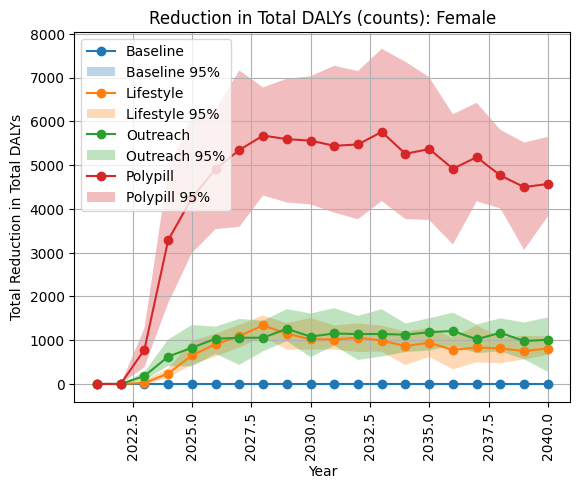

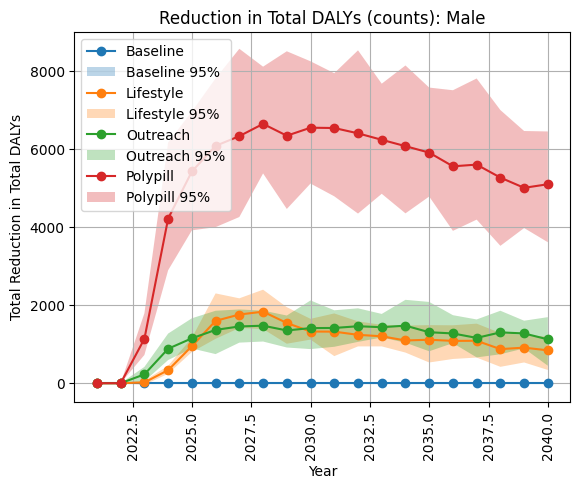

In [24]:
for sex in daly_sum_count.sex.unique(): 
    plt.figure()
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Reduction in Total DALYs (counts): {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Total DALYs')

Note: this has NOT been multipled up to represent all of Alabama. It is useful for visualization but not the actual value of numbers. 

## DALYs Averted by Age Group

In [57]:
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total['age_bucket'] = np.where(np.isin(daly_total['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(daly_total['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(daly_total['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
daly_total = daly_total.groupby(['age_bucket','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

age_bucket  input_draw  year       scenario           daly
0   45_to_65          29  2021       baseline  336645.965045
1   45_to_65          29  2021  lifestyle_100  336645.965045
2   45_to_65          29  2021   outreach_100  336645.965045
3   45_to_65          29  2021   polypill_100  336645.965045
4   45_to_65          29  2022       baseline  307996.539320

In [58]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
per_time_group = person_time.groupby(['age_bucket', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [59]:
daly_total_rate = daly_total.merge(per_time_group[['age_bucket','input_draw','year','scenario','ptvalue']], on=['age_bucket','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

age_bucket  input_draw  year       scenario           daly       ptvalue  \
0   45_to_65          29  2021       baseline  336645.965045  1.489425e+06   
1   45_to_65          29  2021  lifestyle_100  336645.965045  1.489425e+06   
2   45_to_65          29  2021   outreach_100  336645.965045  1.489425e+06   
3   45_to_65          29  2021   polypill_100  336645.965045  1.489425e+06   
4   45_to_65          29  2022       baseline  307996.539320  1.373620e+06   

   daly_rate  
0   0.226024  
1   0.226024  
2   0.226024  
3   0.226024  
4   0.224223

In [60]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['age_bucket','input_draw','year','baseline']], on=['age_bucket','input_draw','year']) 
daly_total_rate['averted_count'] =  daly_total_rate['baseline'] - daly_total_rate['daly_rate']
daly_total_rate['averted_percent'] = 100*(( daly_total_rate['baseline'] - daly_total_rate['daly_rate'])/daly_total_rate['baseline'])
daly_total_rate.head()

age_bucket  input_draw  year       scenario           daly       ptvalue  \
0   45_to_65          29  2021       baseline  336645.965045  1.489425e+06   
1   45_to_65          29  2021  lifestyle_100  336645.965045  1.489425e+06   
2   45_to_65          29  2021   outreach_100  336645.965045  1.489425e+06   
3   45_to_65          29  2021   polypill_100  336645.965045  1.489425e+06   
4   45_to_65          29  2022       baseline  307996.539320  1.373620e+06   

   daly_rate  baseline  averted_count  averted_percent  
0   0.226024  0.226024            0.0              0.0  
1   0.226024  0.226024            0.0              0.0  
2   0.226024  0.226024            0.0              0.0  
3   0.226024  0.226024            0.0              0.0  
4   0.224223  0.224223            0.0              0.0

In [61]:
daly_sum_count = (daly_total_rate
                .groupby(['age_bucket','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

age_bucket  year       scenario  mean  2.5%  97.5%
0   45_to_65  2021       baseline   0.0   0.0    0.0
1   45_to_65  2021  lifestyle_100   0.0   0.0    0.0
2   45_to_65  2021   outreach_100   0.0   0.0    0.0
3   45_to_65  2021   polypill_100   0.0   0.0    0.0
4   45_to_65  2022       baseline   0.0   0.0    0.0

In [62]:
daly_sum_percent = (daly_total_rate
                .groupby(['age_bucket','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

age_bucket  year       scenario  mean  2.5%  97.5%
0   45_to_65  2021       baseline   0.0   0.0    0.0
1   45_to_65  2021  lifestyle_100   0.0   0.0    0.0
2   45_to_65  2021   outreach_100   0.0   0.0    0.0
3   45_to_65  2021   polypill_100   0.0   0.0    0.0
4   45_to_65  2022       baseline   0.0   0.0    0.0

In [63]:
##Polypill Scenario First 
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Polypill Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

AttributeError: 'DataFrame' object has no attribute 'sex'

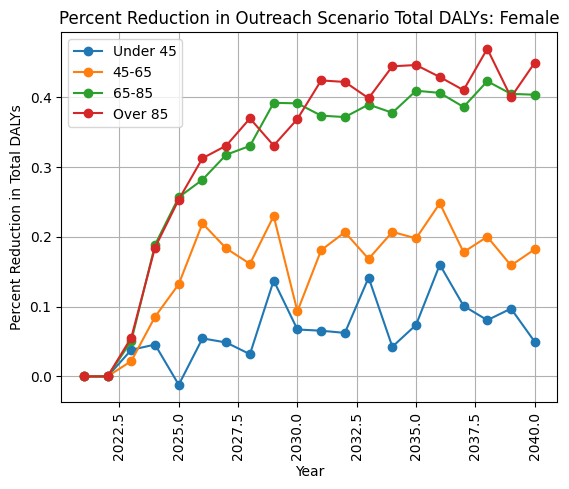

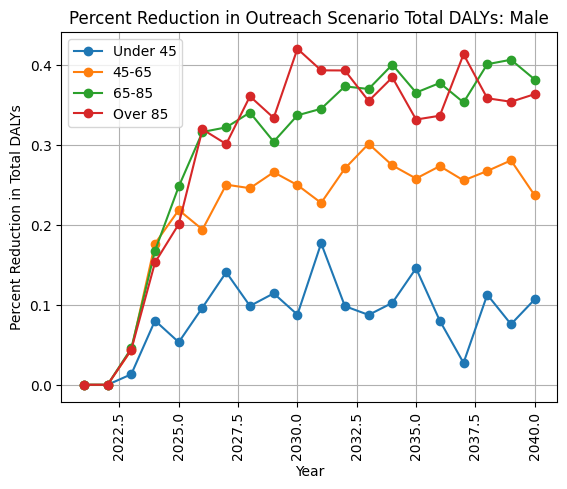

In [32]:
##Outreach Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Outreach Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

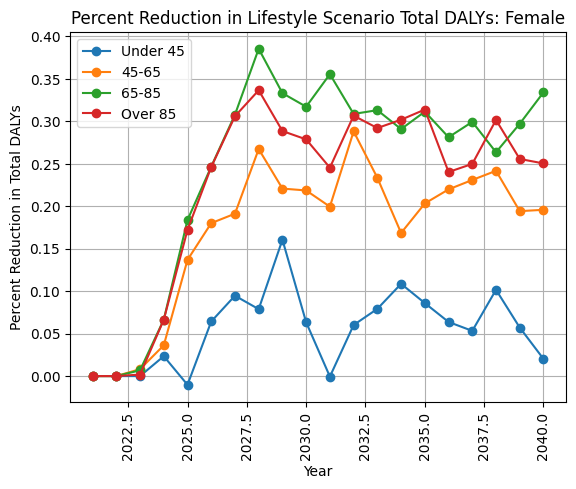

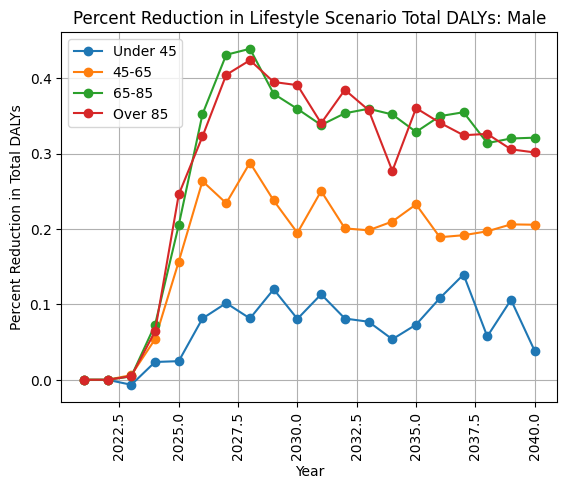

In [33]:
##Lifestyle Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Lifestyle Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

# Figure All together

In [64]:
daly_sum_count

age_bucket  year       scenario      mean      2.5%     97.5%
0     45_to_65  2021       baseline  0.000000  0.000000  0.000000
1     45_to_65  2021  lifestyle_100  0.000000  0.000000  0.000000
2     45_to_65  2021   outreach_100  0.000000  0.000000  0.000000
3     45_to_65  2021   polypill_100  0.000000  0.000000  0.000000
..         ...   ...            ...       ...       ...       ...
316   under_45  2040       baseline  0.000000  0.000000  0.000000
317   under_45  2040  lifestyle_100  0.000030 -0.000063  0.000190
318   under_45  2040   outreach_100  0.000080 -0.000001  0.000224
319   under_45  2040   polypill_100  0.000232  0.000147  0.000400

[320 rows x 6 columns]

In [65]:
def nih_us_graphs(data, pdf_title): 
    with PdfPages(pdf_title) as pdf:
        fig = plt.figure(figsize=(8,12))
        fig.subplots_adjust(hspace=0.3, wspace=0.4)
        plt.suptitle(f'Comparing Outcomes by Age Group in Different Scenarios')
        ax = fig.add_subplot(3, 1, 1)

        subdata = data.loc[(data.age_bucket=='under_45') & (data.scenario=='lifestyle_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Under 45')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='45_to_65') & (data.scenario=='lifestyle_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '45 to 65')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='65_to_85') & (data.scenario=='lifestyle_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '65 to 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='over_85') & (data.scenario=='lifestyle_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Over 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Count Reduction in DALYs in the Lifestyle Scenario')
        ax.set_xlabel('Year')
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')
        

        ax = fig.add_subplot(3, 1, 2)

        subdata = data.loc[(data.age_bucket=='under_45') & (data.scenario=='outreach_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Under 45')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='45_to_65') & (data.scenario=='outreach_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '45 to 65')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='65_to_85') & (data.scenario=='outreach_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '65 to 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='over_85') & (data.scenario=='outreach_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Over 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Count Reduction in DALYs in the Outreach Scenario')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('Year')
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')

        ax = fig.add_subplot(3, 1, 3)

        subdata = data.loc[(data.age_bucket=='under_45') & (data.scenario=='polypill_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Under 45')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='45_to_65') & (data.scenario=='polypill_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '45 to 65')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='65_to_85') & (data.scenario=='polypill_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = '65 to 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.age_bucket=='over_85') & (data.scenario=='polypill_100')]
        ax.plot(subdata['year'], subdata['mean'], marker = 'o', label = 'Over 85')
        ax.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Count Reduction in DALYs in the Polypill Scenario')
        ax.set_xlabel('Year')
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')

        pdf.savefig(bbox_inches='tight')

In [66]:
nih_us_graphs(daly_sum_count, 'RATE_dalys_age_group_us_1_17_2023.pdf')

# Deaths Averted

## Total Deaths Averted

In [26]:
deaths_all = deaths.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_all.head()

sex  year  scenario  input_draw   value
0  female  2023  baseline          29  4525.0
1  female  2023  baseline         232  4078.0
2  female  2023  baseline         357  4189.0
3  female  2023  baseline         394  4065.0
4  female  2023  baseline         602  4318.0

In [27]:
deaths_baseline = deaths_all.loc[deaths_all.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_total = deaths_all.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_total['averted_count'] = deaths_total['baseline'] - deaths_total['value']
deaths_total['averted_percent'] = 100*((deaths_total['baseline'] - deaths_total['value'])/deaths_total['baseline'])
deaths_total

sex  year       scenario  input_draw   value  baseline  \
0     female  2023       baseline          29  4525.0    4525.0   
1     female  2023  lifestyle_100          29  4525.0    4525.0   
2     female  2023   lifestyle_50          29  4525.0    4525.0   
3     female  2023   outreach_100          29  4524.0    4525.0   
...      ...   ...            ...         ...     ...       ...   
2516    male  2040   outreach_100         946  5487.0    5481.0   
2517    male  2040    outreach_50         946  5480.0    5481.0   
2518    male  2040   polypill_100         946  5473.0    5481.0   
2519    male  2040    polypill_50         946  5475.0    5481.0   

      averted_count  averted_percent  
0               0.0         0.000000  
1               0.0         0.000000  
2               0.0         0.000000  
3               1.0         0.022099  
...             ...              ...  
2516           -6.0        -0.109469  
2517            1.0         0.018245  
2518            8.0         0.145959  
2519            6.0         0.109469  

[2520 rows x 8 columns]

In [28]:
deaths_summ_count = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.1   0.0  0.775
2  female  2023   lifestyle_50   0.1   0.0  0.775
3  female  2023   outreach_100   1.9   0.0  5.325
4  female  2023    outreach_50   1.4   0.0  3.775

In [29]:
deaths_summ_percent = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.002042   0.0  0.015829
2  female  2023   lifestyle_50  0.002042   0.0  0.015829
3  female  2023   outreach_100  0.043776   0.0  0.130505
4  female  2023    outreach_50  0.032418   0.0  0.092374

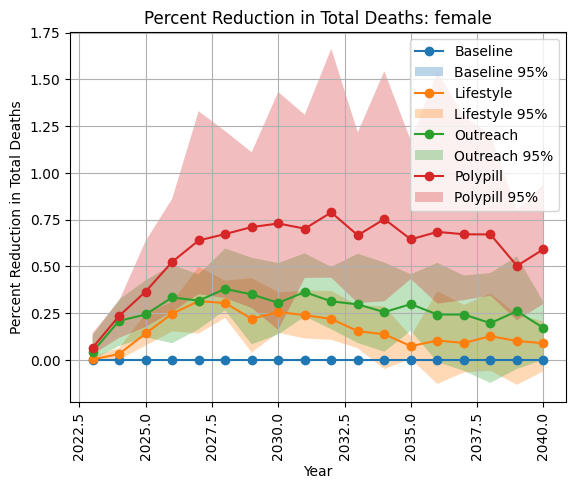

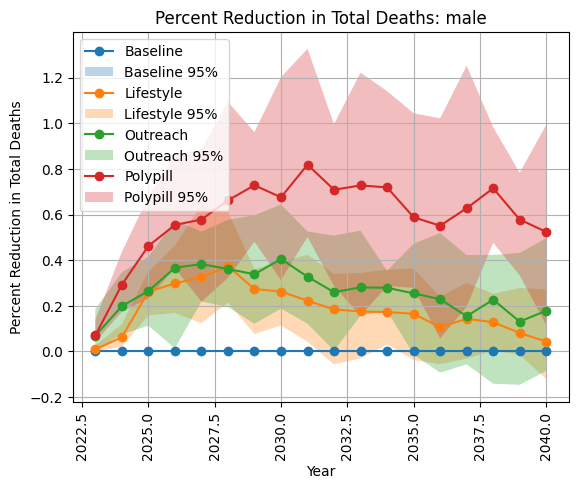

In [30]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total Deaths')


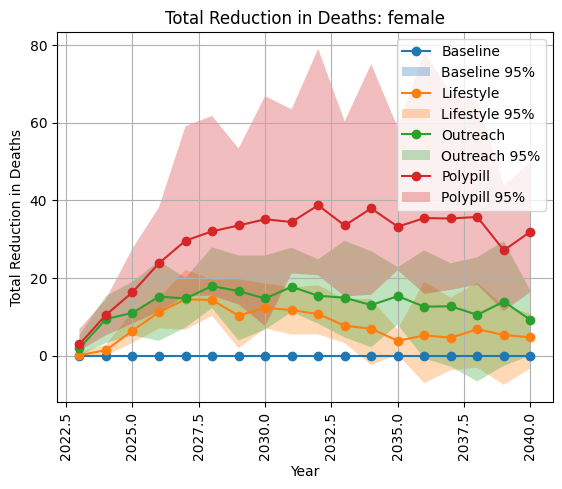

In [31]:
for sex in deaths_summ_count.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Deaths')

Note: This has not been multiplied up to reflect the full population 

## CVD Deaths Averted 

In [32]:
deaths_cvd = deaths.loc[deaths.cause != 'other_causes']
deaths_cvd = deaths_cvd.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_cvd_rate = deaths_cvd.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
deaths_cvd_rate['cvd_death_rate'] = deaths_cvd_rate['value'] / deaths_cvd_rate['ptvalue']
deaths_cvd_rate.head()

sex  year  scenario  input_draw   value        ptvalue  cvd_death_rate
0  female  2023  baseline          29  2520.0  259725.086927        0.009703
1  female  2023  baseline         232  2813.0  260908.254620        0.010782
2  female  2023  baseline         357  2406.0  259679.934292        0.009265
3  female  2023  baseline         394  2923.0  260812.046543        0.011207
4  female  2023  baseline         602  2596.0  260163.734428        0.009978

In [33]:
deaths_baseline = deaths_cvd_rate.loc[deaths_cvd_rate.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_cvd_rate = deaths_cvd_rate.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_cvd_rate['averted_count'] = deaths_cvd_rate['baseline'] - deaths_cvd_rate['value']
deaths_cvd_rate['averted_percent'] = 100*((deaths_cvd_rate['baseline'] - deaths_cvd_rate['value'])/deaths_cvd_rate['baseline'])
deaths_cvd_rate

sex  year       scenario  input_draw   value        ptvalue  \
0     female  2023       baseline          29  2520.0  259725.086927   
1     female  2023  lifestyle_100          29  2520.0  259725.086927   
2     female  2023   lifestyle_50          29  2520.0  259725.086927   
3     female  2023   outreach_100          29  2519.0  259725.240246   
...      ...   ...            ...         ...     ...            ...   
2516    male  2040   outreach_100         946  3628.0  233594.666667   
2517    male  2040    outreach_50         946  3626.0  233456.449008   
2518    male  2040   polypill_100         946  3605.0  233772.057495   
2519    male  2040    polypill_50         946  3615.0  233548.824093   

      cvd_death_rate  baseline  averted_count  averted_percent  
0           0.009703    2520.0            0.0         0.000000  
1           0.009703    2520.0            0.0         0.000000  
2           0.009703    2520.0            0.0         0.000000  
3           0.009699    2520.0            1.0         0.039683  
...              ...       ...            ...              ...  
2516        0.015531    3629.0            1.0         0.027556  
2517        0.015532    3629.0            3.0         0.082667  
2518        0.015421    3629.0           24.0         0.661339  
2519        0.015479    3629.0           14.0         0.385781  

[2520 rows x 10 columns]

In [34]:
deaths_summ_percent = (deaths_cvd_rate
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.003520   0.0  0.027279
2  female  2023   lifestyle_50  0.003520   0.0  0.027279
3  female  2023   outreach_100  0.064494   0.0  0.160624
4  female  2023    outreach_50  0.050171   0.0  0.134110

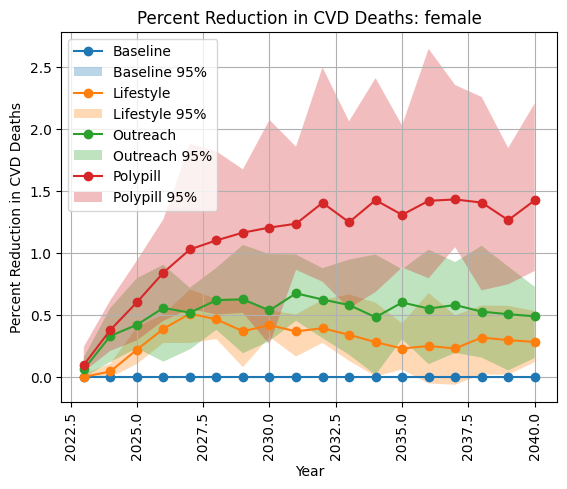

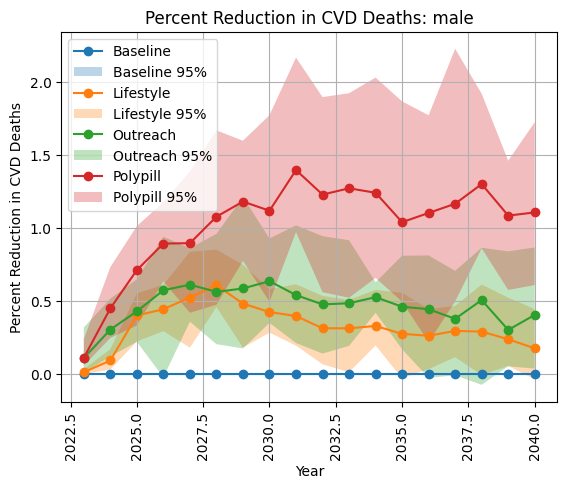

In [35]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in CVD Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in CVD Deaths')


In [36]:
polypill_locations_cvd_deaths = deaths_summ_percent.loc[deaths_summ_percent.scenario=='polypill_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [49]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    polypill_locations_cvd_deaths[state] = polypill_locations_cvd_deaths['mean'] * rand
    for i in range(len(polypill_locations_cvd_deaths)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        polypill_locations_cvd_deaths[state].iloc[i] = polypill_locations_cvd_deaths[state].iloc[i] * rand_2

In [50]:
polypill_locations_cvd_deaths

sex  year      scenario      mean      2.5%     97.5%   Alabama  \
5    female  2023  polypill_100  0.099833  0.046208  0.245019  0.051468   
12   female  2024  polypill_100  0.381706  0.213295  0.621041  0.211928   
19   female  2025  polypill_100  0.604538  0.296999  0.941275  0.312141   
26   female  2026  polypill_100  0.844207  0.455154  1.274182  0.450845   
..      ...   ...           ...       ...       ...       ...       ...   
229    male  2037  polypill_100  1.165232  0.497476  2.225018  0.716975   
236    male  2038  polypill_100  1.299780  0.860796  1.918170  0.823770   
243    male  2039  polypill_100  1.084183  0.575684  1.459709  0.706728   
250    male  2040  polypill_100  1.105835  0.609158  1.722849  0.596294   

     Washington  California  New Jersey  ...    Oregon    Nevada  Mississippi  \
5      0.089754    0.073523    0.085616  ...  0.058003  0.067036     0.084372   
12     0.298315    0.313217    0.301856  ...  0.173144  0.245121     0.331708   
19     0.534476    0.453576    0.586900  ...  0.330987  0.425461     0.562231   
26     0.743474    0.574379    0.747902  ...  0.460417  0.594948     0.841795   
..          ...         ...         ...  ...       ...       ...          ...   
229    0.923461    0.836673    1.081864  ...  0.647259  0.827093     1.194670   
236    1.169463    0.867274    1.210327  ...  0.634301  1.012017     1.197016   
243    0.866765    0.878772    1.014248  ...  0.488380  0.897852     0.944330   
250    1.049127    0.926195    0.951534  ...  0.587412  0.786428     1.111617   

      Georgia      Iowa  Missouri  Arkansas  New York     Maine   Vermont  
5    0.068841  0.124342  0.050240  0.111982  0.131496  0.150228  0.116631  
12   0.247164  0.570367  0.190228  0.545097  0.522483  0.534595  0.504653  
19   0.330095  0.773288  0.388253  0.905227  0.745325  0.840584  0.801364  
26   0.558274  1.022262  0.419325  1.103179  0.970731  1.171457  1.248869  
..        ...       ...       ...       ...       ...       ...       ...  
229  0.804495  1.712498  0.595366  1.405627  1.323653  1.759321  1.583091  
236  0.840805  1.862236  0.816174  1.720947  1.454857  1.753064  1.611104  
243  0.602240  1.464900  0.656059  1.561549  1.239376  1.526952  1.449530  
250  0.793950  1.635379  0.619921  1.259873  1.476455  1.377587  1.322762  

[36 rows x 21 columns]

In [51]:
for sex in polypill_locations_cvd_deaths.sex.unique(): 
    plt.figure()
    subdata = polypill_locations_cvd_deaths.loc[(polypill_locations_cvd_deaths.sex==sex)]
    for state in states: 
        plt.plot(subdata['year'], subdata[state], marker = 'o',label=state)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.title(f'Percent Reduction in CVD Deaths by State: {sex}')
    plt.ylabel('Percent Reduction in CVD Deaths')

# First Time Incident Cases Averted

## Stroke Cases Averted

In [10]:
tran_stroke = tran.loc[tran.transition == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke']
tran_stroke = tran_stroke.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()
tran_stroke

sex  input_draw  year       scenario  value
0     Female         357  2021       baseline  404.0
1     Female         357  2021  lifestyle_100  404.0
2     Female         357  2021   lifestyle_50  404.0
3     Female         357  2021   outreach_100  404.0
...      ...         ...   ...            ...    ...
1396    Male         946  2040   outreach_100  292.0
1397    Male         946  2040    outreach_50  292.0
1398    Male         946  2040   polypill_100  270.0
1399    Male         946  2040    polypill_50  284.0

[1400 rows x 5 columns]

In [11]:
tran_baseline = tran_stroke.loc[tran_stroke.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_stroke = tran_stroke.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_stroke['averted_count'] = tran_stroke['baseline'] - tran_stroke['value']
tran_stroke['averted_percent'] = 100*((tran_stroke['baseline'] - tran_stroke['value'])/tran_stroke['baseline'])
tran_stroke.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  Female         357  2021       baseline  404.0     404.0            0.0   
1  Female         357  2021  lifestyle_100  404.0     404.0            0.0   
2  Female         357  2021   lifestyle_50  404.0     404.0            0.0   
3  Female         357  2021   outreach_100  404.0     404.0            0.0   
4  Female         357  2021    outreach_50  404.0     404.0            0.0   

   averted_percent  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [12]:
stroke_summ_count = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   lifestyle_50   0.0   0.0    0.0
3  Female  2021   outreach_100   0.0   0.0    0.0
4  Female  2021    outreach_50   0.0   0.0    0.0

In [13]:
stroke_summ_percent = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_percent.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   lifestyle_50   0.0   0.0    0.0
3  Female  2021   outreach_100   0.0   0.0    0.0
4  Female  2021    outreach_50   0.0   0.0    0.0

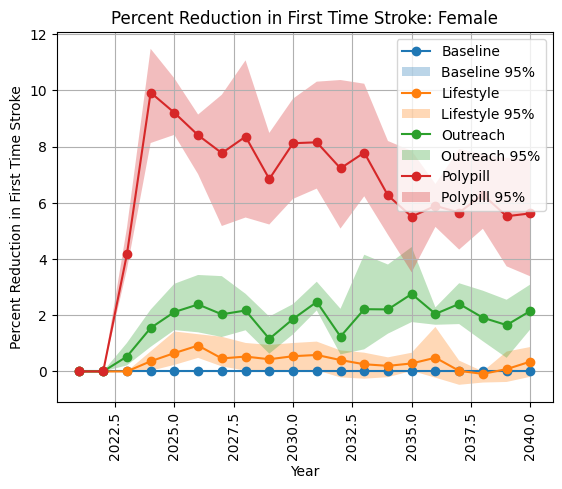

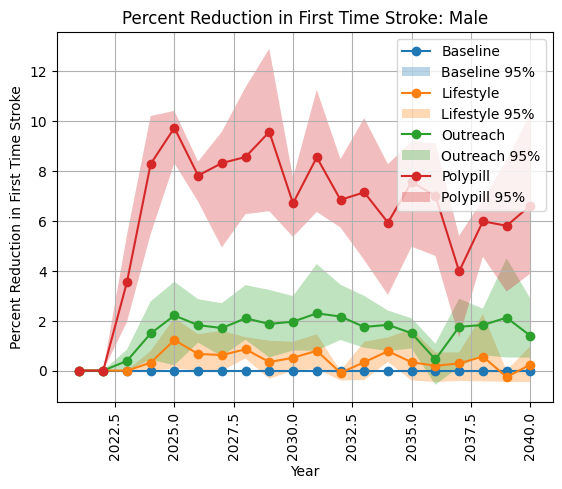

In [14]:
for sex in stroke_summ_percent.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time Stroke')


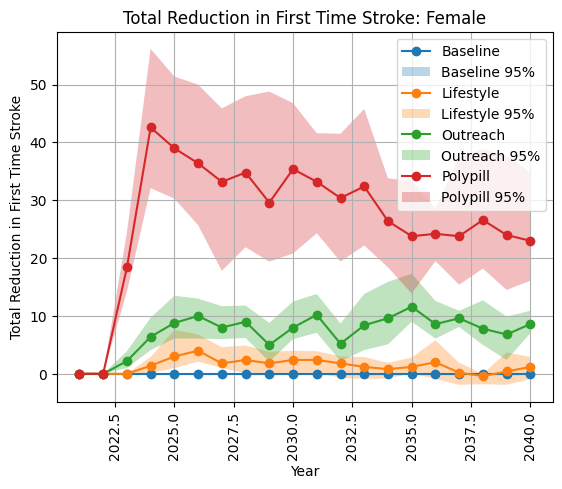

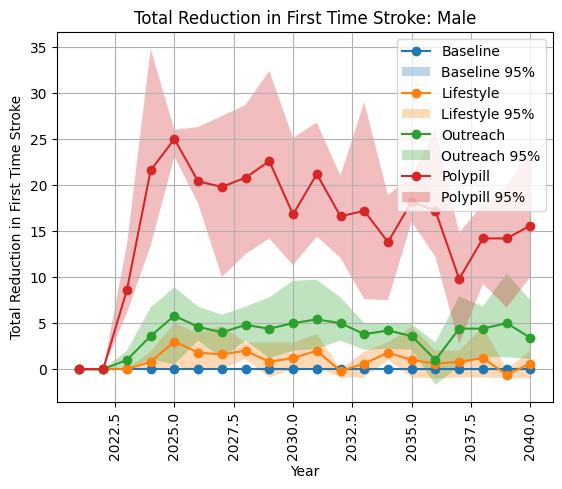

In [15]:
for sex in stroke_summ_count.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time Stroke')


Note: again, not multiplied up to represent all of Alabama

## First Time Acute MI

In [18]:
tran_mi = tran.loc[tran.transition == 'susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']
tran_mi = tran_mi.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()
tran_mi

sex  input_draw  year       scenario  value
0     Female         357  2021       baseline  303.0
1     Female         357  2021  lifestyle_100  303.0
2     Female         357  2021   lifestyle_50  303.0
3     Female         357  2021   outreach_100  303.0
...      ...         ...   ...            ...    ...
1396    Male         946  2040   outreach_100  827.0
1397    Male         946  2040    outreach_50  828.0
1398    Male         946  2040   polypill_100  797.0
1399    Male         946  2040    polypill_50  815.0

[1400 rows x 5 columns]

In [19]:
tran_baseline = tran_mi.loc[tran_mi.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_mi = tran_mi.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_mi['averted_count'] = tran_mi['baseline'] - tran_mi['value']
tran_mi['averted_percent'] = 100*((tran_mi['baseline'] - tran_mi['value'])/tran_mi['baseline'])
tran_mi.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  Female         357  2021       baseline  303.0     303.0            0.0   
1  Female         357  2021  lifestyle_100  303.0     303.0            0.0   
2  Female         357  2021   lifestyle_50  303.0     303.0            0.0   
3  Female         357  2021   outreach_100  303.0     303.0            0.0   
4  Female         357  2021    outreach_50  303.0     303.0            0.0   

   averted_percent  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [20]:
mi_summ_count = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   lifestyle_50   0.0   0.0    0.0
3  Female  2021   outreach_100   0.0   0.0    0.0
4  Female  2021    outreach_50   0.0   0.0    0.0

In [21]:
mi_summ_percent = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_percent.head()

sex  year       scenario  mean  2.5%  97.5%
0  Female  2021       baseline   0.0   0.0    0.0
1  Female  2021  lifestyle_100   0.0   0.0    0.0
2  Female  2021   lifestyle_50   0.0   0.0    0.0
3  Female  2021   outreach_100   0.0   0.0    0.0
4  Female  2021    outreach_50   0.0   0.0    0.0

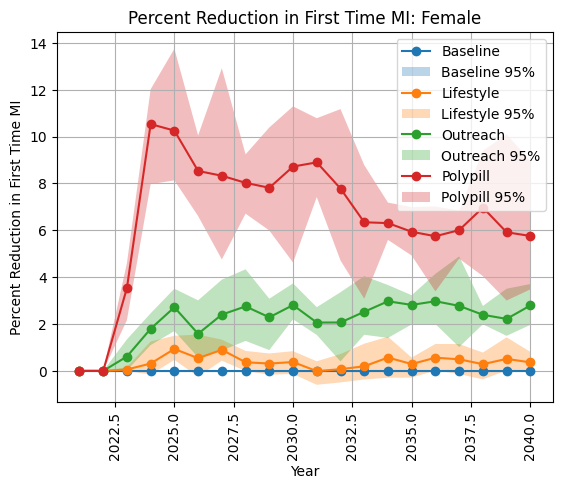

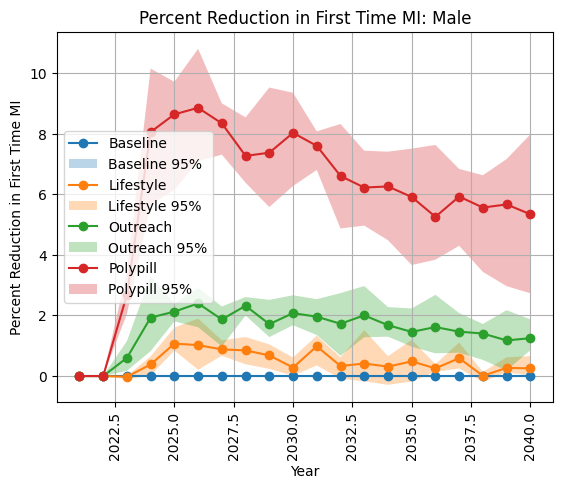

In [22]:
for sex in mi_summ_percent.sex.unique(): 
    plt.figure()
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time MI')


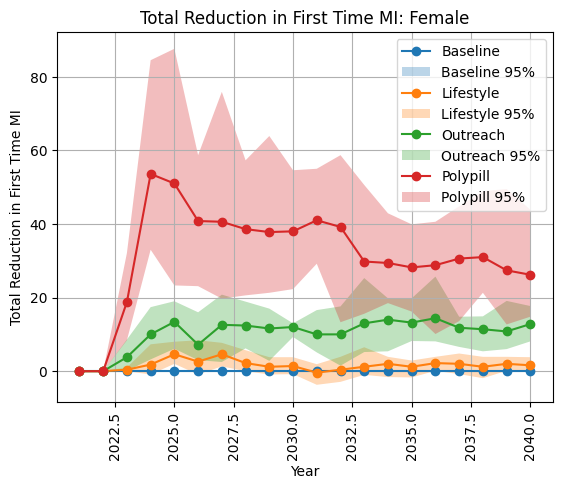

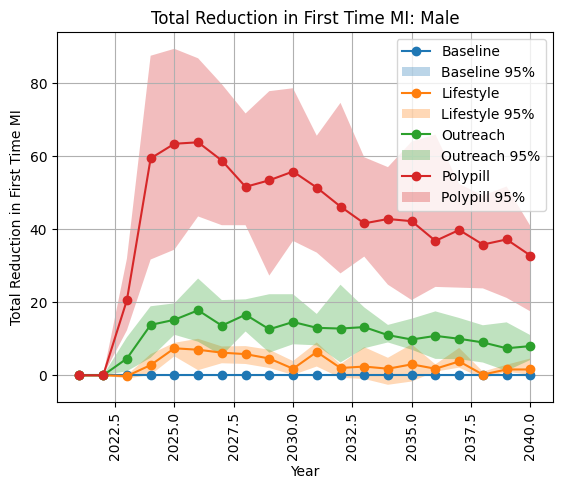

In [23]:
for sex in mi_summ_count.sex.unique(): 
    plt.figure()
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time MI')


## And First Time Heart Failure

In [49]:
tran_HF = tran.loc[(tran['transition'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_HF['age_bucket'] = np.where(np.isin(tran_HF['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(tran_HF['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(tran_HF['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
tran_HF_sex = tran_HF.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age = tran_HF.groupby(['sex','age','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket = tran_HF.groupby(['sex','age_bucket','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket.head()

sex age_bucket  input_draw  year       scenario  value
0  Female   45_to_65         357  2021       baseline  261.0
1  Female   45_to_65         357  2021  lifestyle_100  261.0
2  Female   45_to_65         357  2021   lifestyle_50  261.0
3  Female   45_to_65         357  2021   outreach_100  261.0
4  Female   45_to_65         357  2021    outreach_50  261.0

In [50]:
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket = person_time.groupby(['sex','age_bucket', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket.head()

sex age_bucket  year  input_draw       scenario       ptvalue
0  Female   45_to_65  2021         357       baseline  75751.096509
1  Female   45_to_65  2021         357  lifestyle_100  75751.096509
2  Female   45_to_65  2021         357   lifestyle_50  75751.096509
3  Female   45_to_65  2021         357   outreach_100  75751.096509
4  Female   45_to_65  2021         357    outreach_50  75751.096509

In [55]:
tran_HF_rate = tran_HF_sex.merge(per_time_group[['sex', 'year', 'input_draw','scenario','ptvalue']], on=['sex','year', 'input_draw','scenario'])
tran_HF_rate['hf_rate'] = tran_HF_rate['value'] / tran_HF_rate['ptvalue']
tran_baseline = tran_HF_rate.loc[tran_HF_rate.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'hf_rate':'baseline'})
tran_HF_rate = tran_HF_rate.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_HF_rate['averted_count'] = tran_HF_rate['baseline'] - tran_HF_rate['hf_rate']
tran_HF_rate['averted_percent'] = 100*((tran_HF_rate['baseline'] - tran_HF_rate['hf_rate'])/tran_HF_rate['baseline'])
tran_HF_rate.loc[tran_HF_rate.averted_count < 0]#.head()

sex  input_draw  year      scenario   value        ptvalue   hf_rate  \
19    Female         357  2023  polypill_100  1614.0  191687.655031  0.008420   
52    Female         357  2028  outreach_100  1770.0  194597.201916  0.009096   
53    Female         357  2028   outreach_50  1772.0  194589.459274  0.009106   
66    Female         357  2030  outreach_100  1704.0  195249.960301  0.008727   
...      ...         ...   ...           ...     ...            ...       ...   
1388    Male         946  2039  lifestyle_50  1819.0  170831.277207  0.010648   
1391    Male         946  2039  polypill_100  1825.0  171391.967146  0.010648   
1396    Male         946  2040  outreach_100  1832.0  170378.217659  0.010753   
1397    Male         946  2040   outreach_50  1825.0  170284.002738  0.010717   

      baseline  averted_count  averted_percent  
19    0.008410      -0.000010        -0.123989  
52    0.009091      -0.000004        -0.047897  
53    0.009091      -0.000015        -0.164931  
66    0.008713      -0.000014        -0.161932  
...        ...            ...              ...  
1388  0.010639      -0.000009        -0.081275  
1391  0.010639      -0.000009        -0.082910  
1396  0.010703      -0.000050        -0.465649  
1397  0.010703      -0.000015        -0.137148  

[215 rows x 10 columns]

In [52]:
HF_summ_percent = (tran_HF_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario  mean  2.5%  97.5%
0  Female   45_to_65  2021       baseline   0.0   0.0    0.0
1  Female   45_to_65  2021  lifestyle_100   0.0   0.0    0.0
2  Female   45_to_65  2021   lifestyle_50   0.0   0.0    0.0
3  Female   45_to_65  2021   outreach_100   0.0   0.0    0.0
4  Female   45_to_65  2021    outreach_50   0.0   0.0    0.0

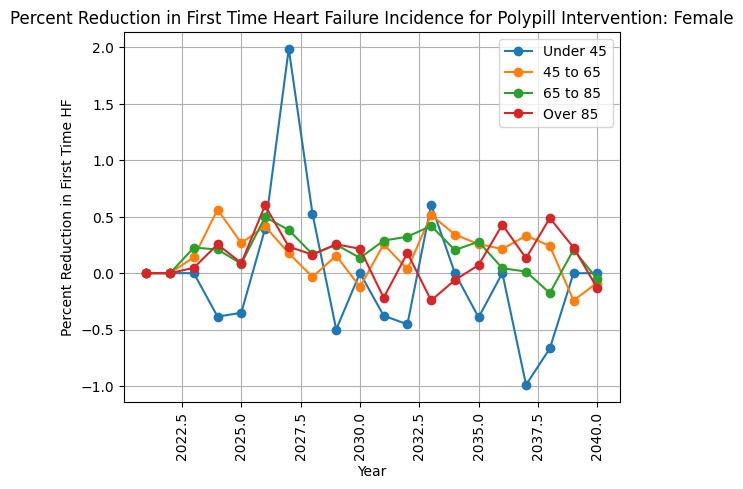

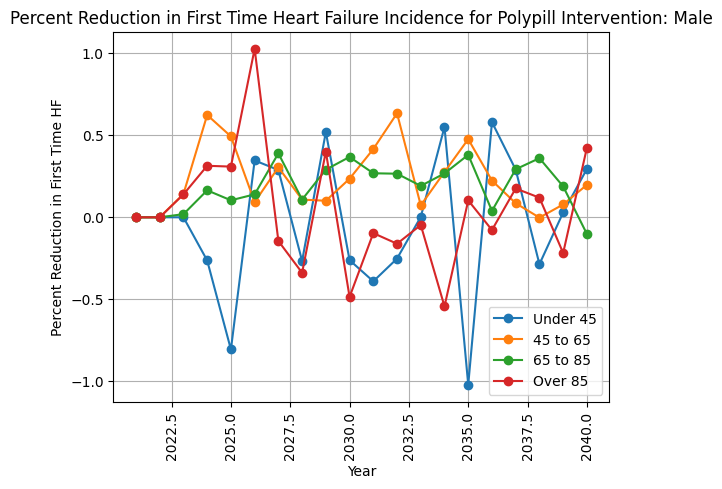

In [53]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure Incidence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Percent Reduction in Heart Failure Prevalence

In [41]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
state_person_time_hf = state_person_time.loc[state_person_time['state'].isin(['acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual'])].reset_index()
state_person_time_hf['age_bucket'] = np.where(np.isin(state_person_time_hf['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(state_person_time_hf['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(state_person_time_hf['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
hf_per_time_sex = state_person_time_hf.groupby(['sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age = state_person_time_hf.groupby(['age','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket = state_person_time_hf.groupby(['age_bucket','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket.head()

age_bucket     sex  year  input_draw       scenario       value
0   45_to_65  Female  2021         357       baseline  908.342231
1   45_to_65  Female  2021         357  lifestyle_100  908.342231
2   45_to_65  Female  2021         357   lifestyle_50  908.342231
3   45_to_65  Female  2021         357   outreach_100  908.342231
4   45_to_65  Female  2021         357    outreach_50  908.342231

In [42]:
hf_prev_rate = hf_per_time_age_bucket.merge(per_time_age_bucket[['sex','age_bucket', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'age_bucket','year', 'input_draw','scenario'])
hf_prev_rate['hf_prev_rate'] = hf_prev_rate['value'] / hf_prev_rate['ptvalue']
hf_prev_baseline = hf_prev_rate.loc[hf_prev_rate.scenario == 'baseline']
hf_prev_baseline = hf_prev_baseline.rename(columns = {'hf_prev_rate':'baseline'})
hf_prev_rate = hf_prev_rate.merge(hf_prev_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
hf_prev_rate['averted_count'] = hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate']
hf_prev_rate['averted_percent'] = 100*((hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate'])/hf_prev_rate['baseline'])
hf_prev_rate.head()

age_bucket     sex  year  input_draw       scenario       value  \
0   45_to_65  Female  2021         357       baseline  908.342231   
1   45_to_65  Female  2021         357  lifestyle_100  908.342231   
2   45_to_65  Female  2021         357   lifestyle_50  908.342231   
3   45_to_65  Female  2021         357   outreach_100  908.342231   
4   45_to_65  Female  2021         357    outreach_50  908.342231   

        ptvalue  hf_prev_rate  baseline  averted_count  averted_percent  
0  75751.096509      0.011991  0.011991            0.0              0.0  
1  75751.096509      0.011991  0.011991            0.0              0.0  
2  75751.096509      0.011991  0.011991            0.0              0.0  
3  75751.096509      0.011991  0.011991            0.0              0.0  
4  75751.096509      0.011991  0.011991            0.0              0.0

In [44]:
HF_summ_percent = (hf_prev_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario  mean  2.5%  97.5%
0  Female   45_to_65  2021       baseline   0.0   0.0    0.0
1  Female   45_to_65  2021  lifestyle_100   0.0   0.0    0.0
2  Female   45_to_65  2021   lifestyle_50   0.0   0.0    0.0
3  Female   45_to_65  2021   outreach_100   0.0   0.0    0.0
4  Female   45_to_65  2021    outreach_50   0.0   0.0    0.0

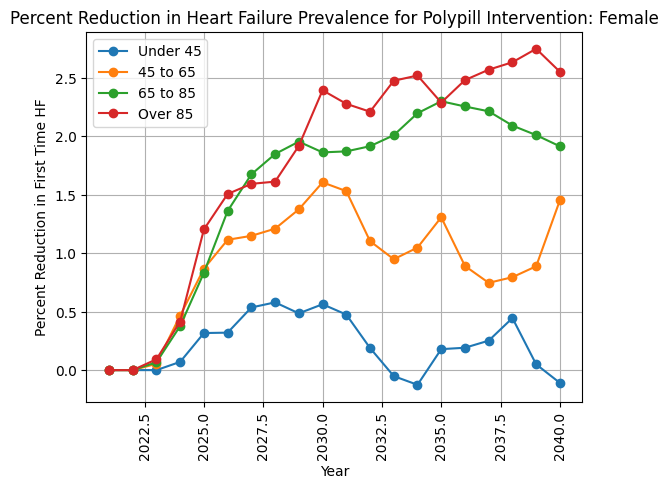

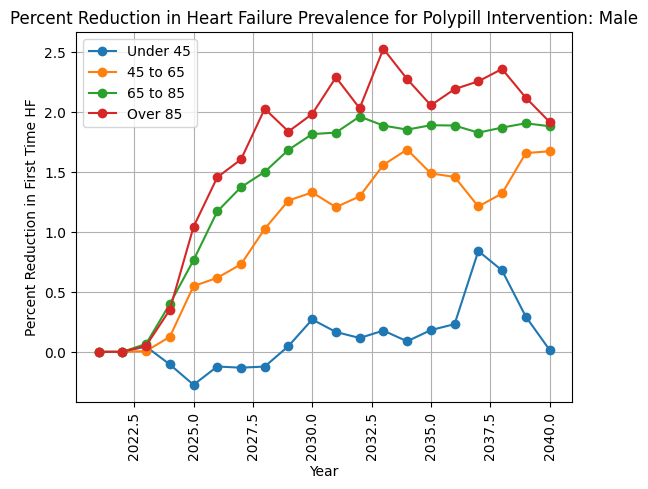

In [45]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

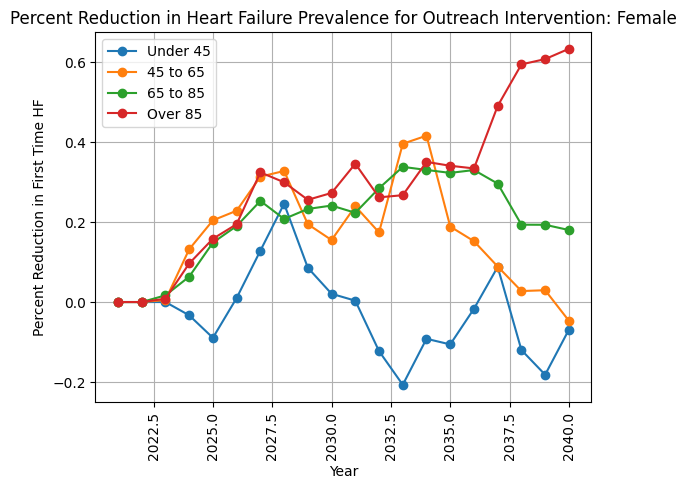

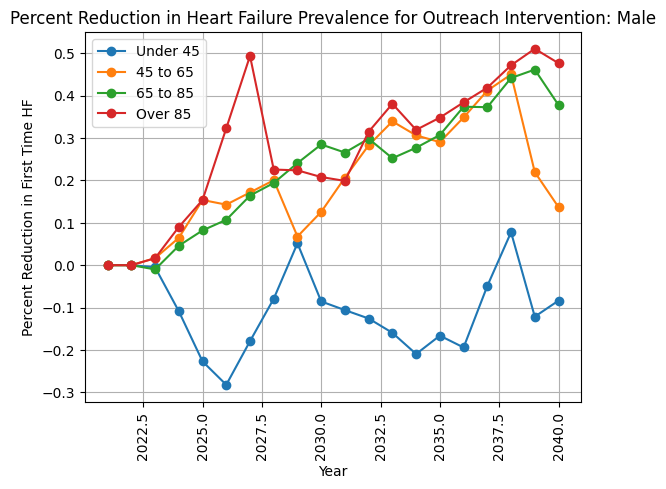

In [46]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

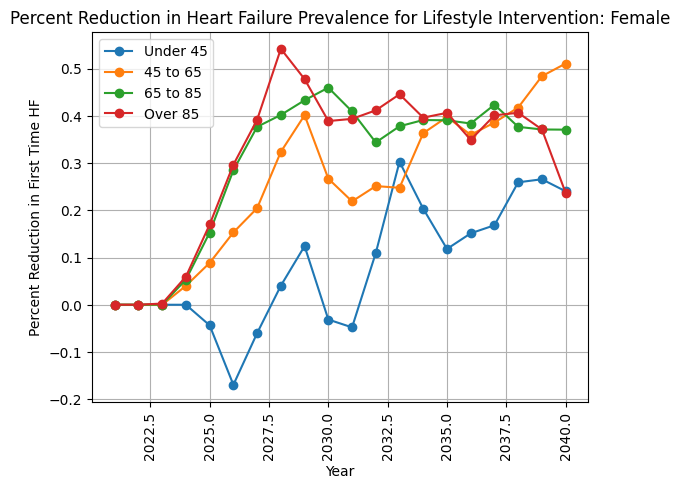

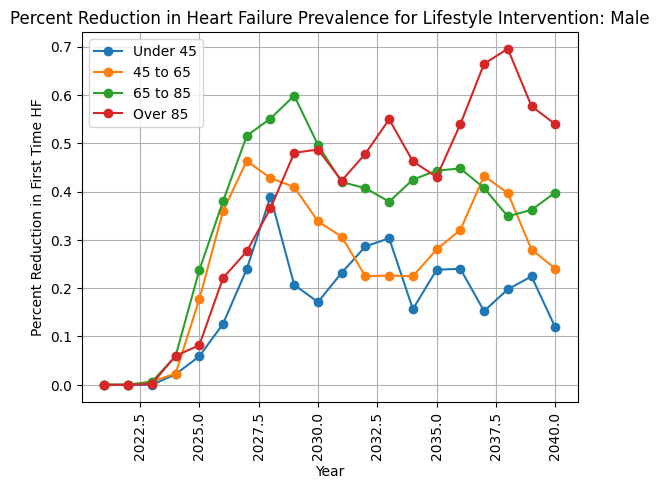

In [47]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Testing Input Draws

### HF Prevalence Time Averted

In [116]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_hf = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease"])].reset_index()
person_time_hf = person_time_hf.rename(columns = {'value':'ptvalue'})
per_time_group_hf = person_time_hf.groupby(['year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [117]:
hf_baseline = per_time_group_hf.loc[per_time_group_hf.scenario == 'baseline']
hf_baseline = hf_baseline.rename(columns = {'ptvalue':'baseline'})
HF_rate_prev = per_time_group_hf.merge(hf_baseline[['input_draw','year','baseline']], on=['input_draw','year']) 
HF_rate_prev['averted_count'] = HF_rate_prev['baseline'] - HF_rate_prev['ptvalue']
HF_rate_prev['averted_percent'] = 100*((HF_rate_prev['baseline'] - HF_rate_prev['ptvalue'])/HF_rate_prev['baseline'])
HF_rate_prev.head()

year  input_draw       scenario       ptvalue      baseline  averted_count  \
0  2023          29       baseline  16682.403833  16682.403833       0.000000   
1  2023          29  lifestyle_100  16681.637235  16682.403833       0.766598   
2  2023          29   lifestyle_50  16681.790554  16682.403833       0.613279   
3  2023          29   outreach_100  16680.640657  16682.403833       1.763176   
4  2023          29    outreach_50  16680.947296  16682.403833       1.456537   

   averted_percent  
0         0.000000  
1         0.004595  
2         0.003676  
3         0.010569  
4         0.008731

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

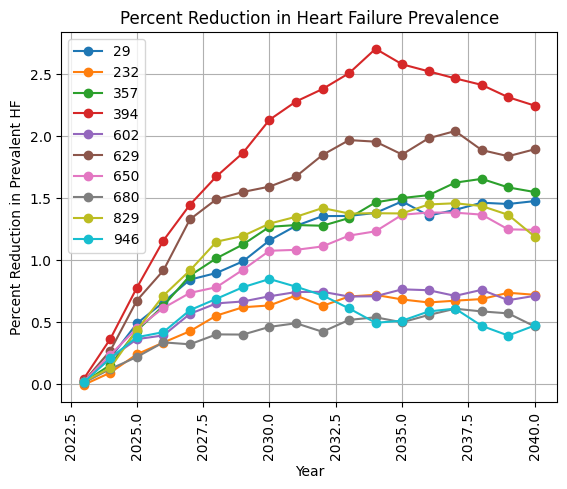

In [119]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

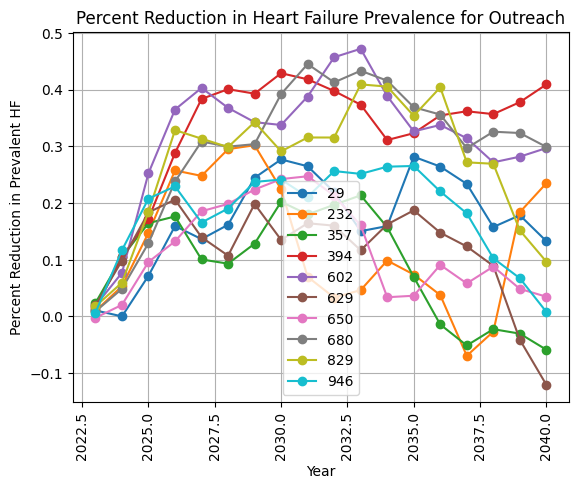

In [120]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

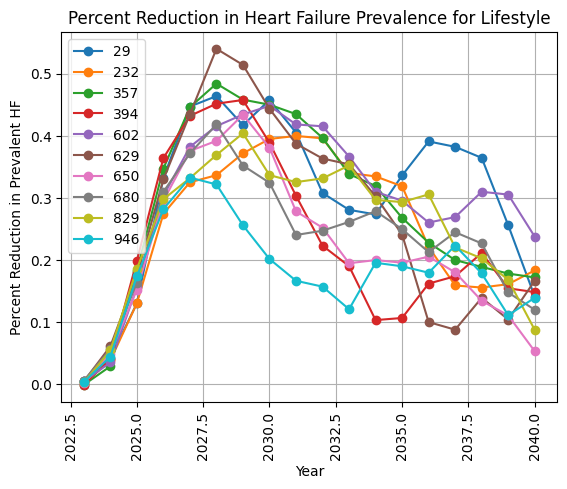

In [121]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

### DALYs Averted

In [15]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  
0   0.324217  
1   0.324217  
2   0.324217  
3   0.324164  
4   0.324164

In [16]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['daly_rate'] - daly_total_rate['baseline']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['daly_rate'] - daly_total_rate['baseline'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  baseline  averted_count  averted_percent  
0   0.324217  0.324217   0.000000e+00         0.000000  
1   0.324217  0.324217  -3.734475e-07        -0.000115  
2   0.324217  0.324217  -3.734475e-07        -0.000115  
3   0.324164  0.324217  -5.351923e-05        -0.016507  
4   0.324164  0.324217  -5.294003e-05        -0.016329

Text(0, 0.5, 'Percent Reduction in DALYs')

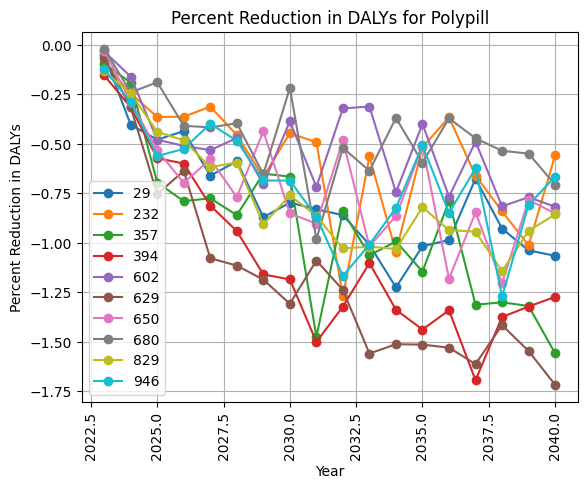

In [20]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Polypill')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

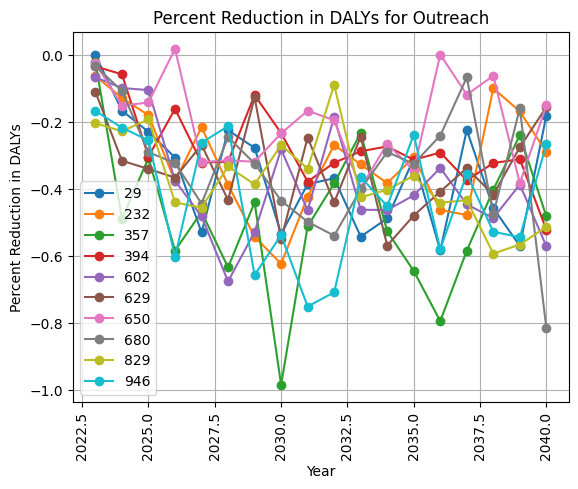

In [21]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Outreach')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

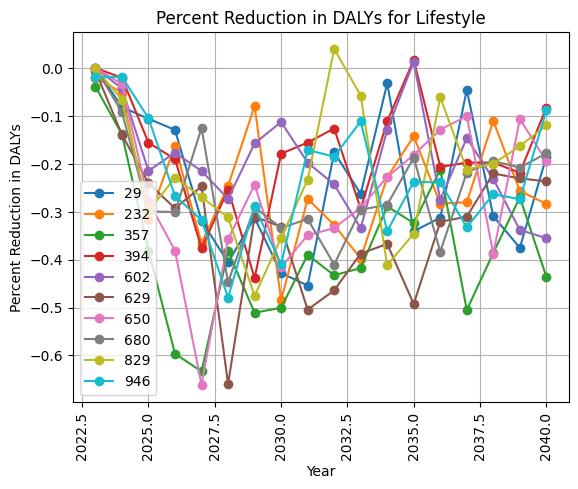

In [22]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='male') & (daly_total_rate.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Lifestyle')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

## Risk Exposures

In [89]:
risks = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
risks.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1           1  female  2023  high_body_mass_index_in_adults   
2           2  female  2023  high_body_mass_index_in_adults   
3           3  female  2023  high_body_mass_index_in_adults   
4           4  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age          value  
0  risk_exposure_time          29       baseline  25_to_29  835692.780297  
1  risk_exposure_time          29  lifestyle_100  25_to_29  835692.780297  
2  risk_exposure_time          29   lifestyle_50  25_to_29  835692.780297  
3  risk_exposure_time          29   outreach_100  25_to_29  835692.780297  
4  risk_exposure_time          29    outreach_50  25_to_29  835692.780297

In [86]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex       age  year  input_draw       scenario      ptvalue
0  female  25_to_29  2023          29       baseline  27022.28063
1  female  25_to_29  2023          29  lifestyle_100  27022.28063
2  female  25_to_29  2023          29   lifestyle_50  27022.28063
3  female  25_to_29  2023          29   outreach_100  27022.28063
4  female  25_to_29  2023          29    outreach_50  27022.28063

In [95]:
risk_exp = risks.merge(per_time_age[['sex','age','input_draw','year','scenario','ptvalue']], on=['sex','age','input_draw','year','scenario'])
risk_exp['risk_exp'] = risk_exp['value'] / risk_exp['ptvalue']
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1        1050  female  2023     high_fasting_plasma_glucose   
2        2100  female  2023            high_ldl_cholesterol   
3        3150  female  2023    high_systolic_blood_pressure   
4           1  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age         value  \
0  risk_exposure_time          29       baseline  25_to_29  8.356928e+05   
1  risk_exposure_time          29       baseline  25_to_29  1.320725e+05   
2  risk_exposure_time          29       baseline  25_to_29  7.654238e+04   
3  risk_exposure_time          29       baseline  25_to_29  2.911479e+06   
4  risk_exposure_time          29  lifestyle_100  25_to_29  8.356928e+05   

       ptvalue    risk_exp  
0  27022.28063   30.926064  
1  27022.28063    4.887540  
2  27022.28063    2.832565  
3  27022.28063  107.743658  
4  27022.28063   30.926064

In [96]:
risk_exp = (risk_exp
                      .groupby(['sex','age', 'year','scenario','risk'])
                      .risk_exp.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

risk_exp.head()

sex       age  year       scenario                            risk  \
0  female  25_to_29  2023       baseline  high_body_mass_index_in_adults   
1  female  25_to_29  2023       baseline     high_fasting_plasma_glucose   
2  female  25_to_29  2023       baseline            high_ldl_cholesterol   
3  female  25_to_29  2023       baseline    high_systolic_blood_pressure   
4  female  25_to_29  2023  lifestyle_100  high_body_mass_index_in_adults   

         mean        2.5%       97.5%  
0   30.715274   30.390470   31.006332  
1    5.341261    4.846877    6.187954  
2    2.634736    2.558028    2.799935  
3  110.017126  107.879221  112.581477  
4   30.715274   30.390470   31.006332

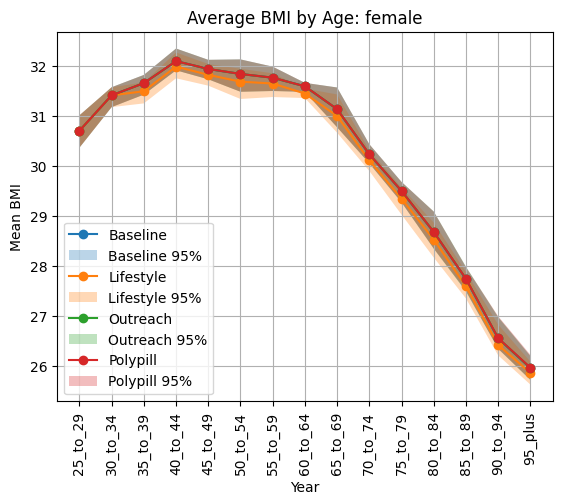

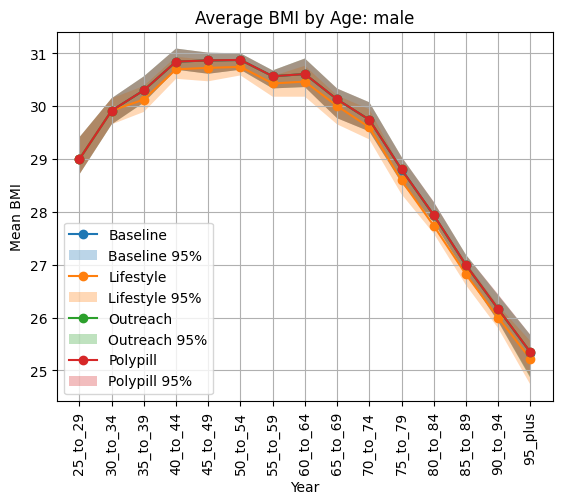

In [105]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average BMI by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean BMI')

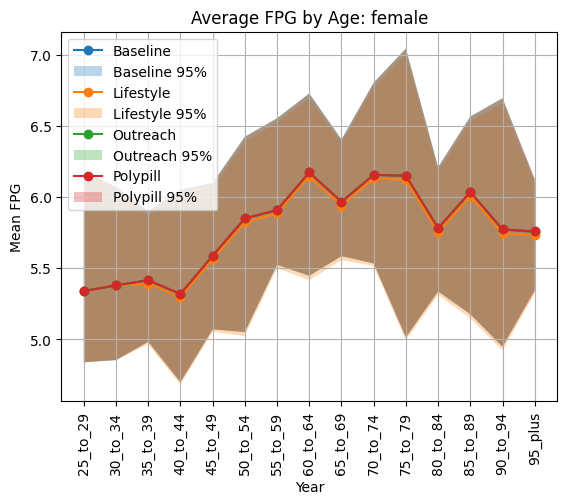

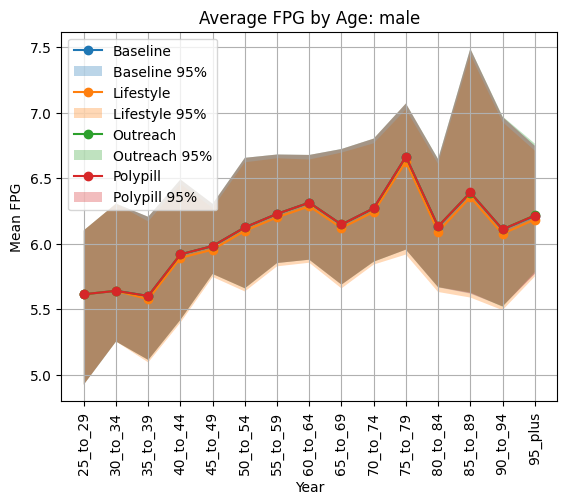

In [107]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average FPG by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean FPG')

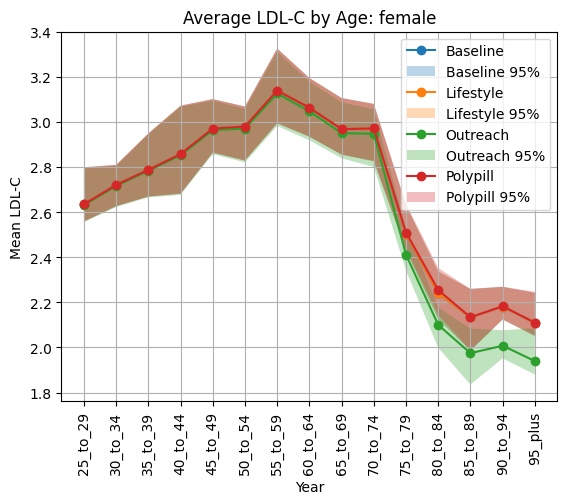

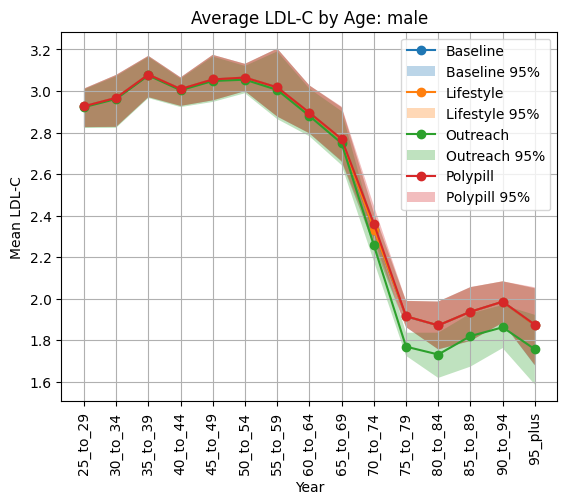

In [108]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average LDL-C by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean LDL-C')

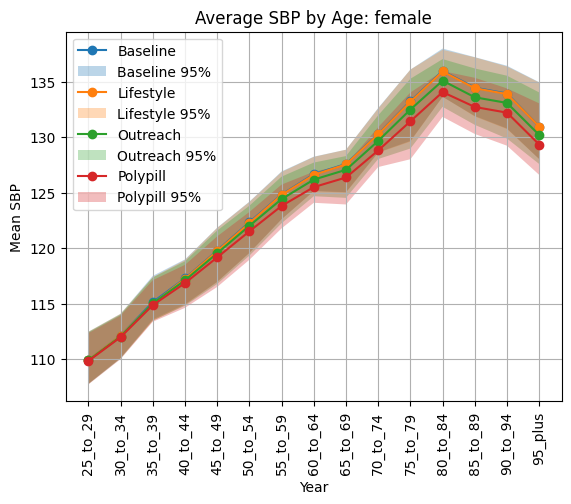

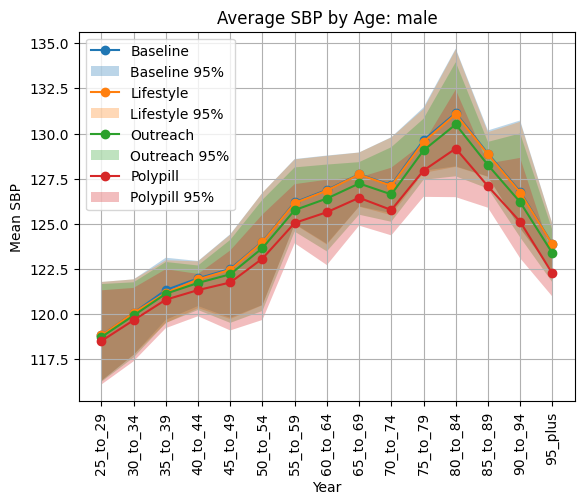

In [109]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average SBP by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean SBP')